# Relatório COVID-19 AM

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import requests
import gzip
import plotly.graph_objects as go
import datetime
from datetime import datetime
from datetime import timedelta
from calendar import month_abbr
from os import environ

In [2]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sklearn.neighbors import KNeighborsRegressor
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import ReducedForecaster

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from numpy import ravel
import sklearn.model_selection
from sktime.forecasting.compose import RecursiveRegressionForecaster

In [4]:
url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv.gz?raw=true'
r = requests.get(url, allow_redirects=True)
open('data.csv.gz','wb').write(r.content)
gz = gzip.open('data.csv.gz')
df = pd.read_csv(gz)

## Validação de Modelos

In [5]:
total_de_casos_amazonas = df.query("state == 'AM'").groupby('date').sum()

In [6]:
total_de_casos_amazonas.index = pd.to_datetime(total_de_casos_amazonas.index)

In [7]:
total_de_casos_amazonas.index.freq = 'D'

In [8]:
def media_ponderada(x,y):
    if knn_taxa > random_forest_taxa:
        return (x * 2 + y) / 3
    return (y * 2 + x) / 3

In [55]:
y = total_de_casos_amazonas.iloc[:-20]['newCases']

In [56]:
SEED = 4

In [57]:
y_train, y_test = temporal_train_test_split(y, test_size= 7)

In [58]:
#X = pd.Series(np.arange(len(y_train)), index=y_train.index)

In [59]:
fh = np.arange(1, len(y_test) + 1)

In [60]:
from sktime.forecasting.naive import NaiveForecaster

In [61]:
dummy = NaiveForecaster(sp = 7)

In [62]:
dummy.fit(y_train)

NaiveForecaster(sp=7)

In [63]:
dummy_pred = dummy.predict(fh)

In [64]:
smape_loss(y_test, dummy_pred)

0.29580619818551596

In [65]:
from sklearn.neighbors import KNeighborsRegressor

In [66]:
list_of_smape = []

for i in range(1,100):
    model = RandomForestRegressor(max_depth=100,  min_samples_split=10, n_estimators=10, random_state=SEED, n_jobs=-1)
    reduced_reg = RecursiveRegressionForecaster(regressor = model, window_length= 7)
    reduced_reg.fit(y_train)
    y_pred = reduced_reg.predict(fh)
    list_of_smape.append([smape_loss(y_test, y_pred), i])


In [67]:
min(list_of_smape)

[0.33160959146788277, 37]

In [68]:
random_forest_test = RecursiveRegressionForecaster(regressor = RandomForestRegressor(max_depth=100,  min_samples_split=10, n_estimators=10, random_state=SEED, n_jobs=-1), window_length= 7)
random_forest_test.fit(y_train)
random_forest_test_pred = reduced_reg.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='newCases'>)

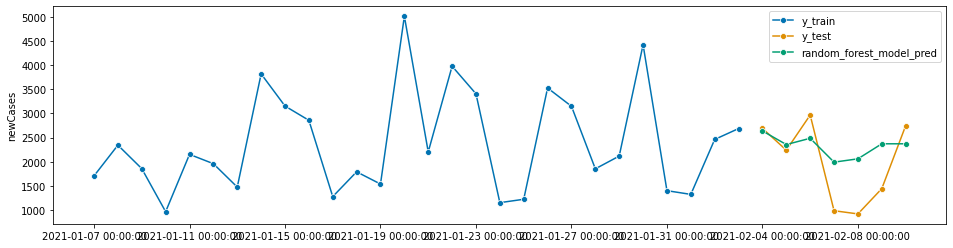

In [69]:
plot_series(y_train[300:], y_test, random_forest_test_pred, labels=["y_train", "y_test", "random_forest_model_pred"])

In [70]:
list_of_smape = []
for i in range(1, 25):
    regressor = KNeighborsRegressor(n_neighbors = i, n_jobs= -1, metric='manhattan')
    reduced_reg = RecursiveRegressionForecaster(regressor = regressor, window_length= 7)
    reduced_reg.fit(y_train)
    y_pred = reduced_reg.predict(fh)
    list_of_smape.append([smape_loss(y_test, y_pred), i])
    

In [71]:
min(list_of_smape)

[0.29525235546773326, 5]

In [72]:
knn_test = RecursiveRegressionForecaster(regressor = KNeighborsRegressor(metric='manhattan', n_neighbors=22, n_jobs= -1), window_length= 7)
knn_test.fit(y_train)
knn_test_pred = reduced_reg.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='newCases'>)

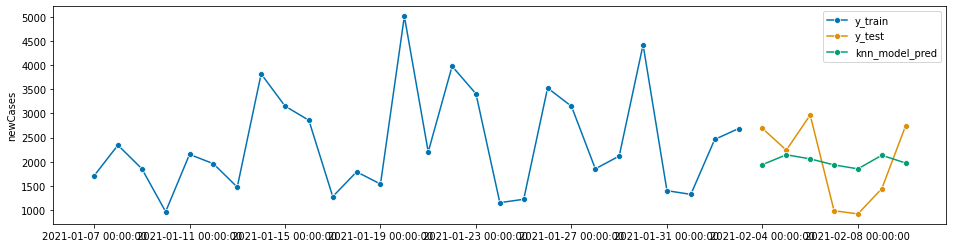

In [73]:
plot_series(y_train[300:], y_test, knn_test_pred, labels=["y_train", "y_test", "knn_model_pred"])

In [74]:
def media_ponderada(x,y):
    if knn_taxa > random_forest_taxa:
        return (x * 2 + y) / 3
    return (y * 2 + x) / 3

In [75]:
knn_taxa = smape_loss(y_test, knn_test_pred)

In [76]:
random_forest_taxa = smape_loss(y_test, random_forest_test_pred)

In [77]:
media_pred = pd.Series([round(media_ponderada(x,y)) for x,y in zip(knn_test_pred, random_forest_test_pred)], index=random_forest_test_pred.index)

In [78]:
media_taxa = smape_loss(y_test, media_pred)

## Previsões

In [79]:
knn_taxa

0.3950776055824735

In [80]:
random_forest_taxa

0.3316095914678828

In [81]:
knn_model = RecursiveRegressionForecaster(regressor = KNeighborsRegressor(metric='manhattan', n_neighbors=12), window_length= 7)
knn_model.fit(total_de_casos_amazonas['newCases'])
knn_model_pred = knn_model.predict(fh)

In [82]:
knn_model_pred = round(knn_model_pred).apply(lambda x: int(x))

In [83]:
random_forest_model = RecursiveRegressionForecaster(regressor = RandomForestRegressor(max_depth=10,  min_samples_split=10, n_estimators=30, random_state=SEED, n_jobs=-1), window_length= 7)
random_forest_model.fit(total_de_casos_amazonas['newCases'])
random_forest_model_pred = random_forest_model.predict(fh)

In [84]:
random_forest_model_pred = round(random_forest_model_pred).apply(lambda x: int(x))

In [85]:
media = pd.Series([round(media_ponderada(x,y)) for x,y in zip(knn_model_pred, random_forest_model_pred)], index=knn_model_pred.index)

In [86]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=knn_model_pred.index,
                        y=knn_model_pred.values,
                        hovertemplate="%{y}",
                        name=f'K-ésimo Vizinho mais Próximo'))

fig.add_trace(go.Scatter(x=random_forest_model_pred.index,
                        y=random_forest_model_pred.values,
                        hovertemplate="%{y}",
                        name='Floresta Aleatória'))

fig.add_trace(go.Scatter(x=media.index,
                        y=media.values,
                        hovertemplate="%{y}",
                        name='Média Ponderada'))

fig.update_layout(title='Modelos de Previsão para os Próximos 07 Dias', xaxis=dict(title='Data'), yaxis=dict(title='Nº Casos'))

In [87]:
knn_taxa_legenda = "{:.2f}".format(round(knn_taxa * 100, 2)).replace(".",",") + " %"

In [88]:
random_forest_taxa_legenda = "{:.2f}".format(round(random_forest_taxa * 100, 2)).replace(".",",") + " %"

In [89]:
media_taxa_legenda =  "{:.2f}".format(round(media_taxa * 100, 2)).replace(".",",") + " %"

In [90]:
index = ['K-ésimo Vizinho mais Próximo', 'Floresta Aleatória', 'Média Ponderada']

In [91]:
erro_percentual = pd.DataFrame([knn_taxa_legenda, random_forest_taxa_legenda, media_taxa_legenda], columns= ['Erro Percentual'], index=index)

In [92]:
erro_percentual

,Erro Percentual
K-ésimo Vizinho mais Próximo,"39,51 %"
Floresta Aleatória,"33,16 %"
Média Ponderada,"36,70 %"


In [93]:
def to_one(x):
    if x == 0:
        return 1
    return x

In [120]:
from sktime.forecasting.arima import ARIMA

In [101]:
model = ARIMA(order=(2, 1, 2), seasonal_order=(2, 1, 1, 7), maxiter=100)

In [102]:
model.fit(y_train)

ARIMA(maxiter=100, order=(2, 1, 2), seasonal_order=(2, 1, 1, 7))

In [103]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  328
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood               -2389.708
Date:                             Tue, 02 Mar 2021   AIC                           4797.416
Time:                                     19:42:44   BIC                           4831.331
Sample:                                          0   HQIC                          4810.959
                                             - 328                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0590      0.263      0.224      0.823      -0.457       0.575
ar.L1          0.6862      0.106      6.480      0.000       0.479       0.894
ar.L2         -0.1545      0.049     -3.157      0.002      -0.250      -0.059
ma.L1         -1.5797      0.102    -15.511      0.000      -1.779      -1.380
ma.L2          0.7152      0.081      8.850      0.000       0.557       0.874
ar.S.L7        0.1423      0.064      2.224      0.026       0.017       0.268
ar.S.L14       0.1022      0.070      1.456      0.146      -0.035       0.240
ma.S.L7       -0.9642      0.077    -12.511      0.000      -1.115      -0.813
sigma2      1.719e+05    1.1e+04     15.614      0.000     1.5e+05    1.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               349.70
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.06   Skew:                             0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
y_pred = model.predict(fh)

In [105]:
smape_loss(y_test, y_pred)

0.27531764835033296

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='newCases'>)

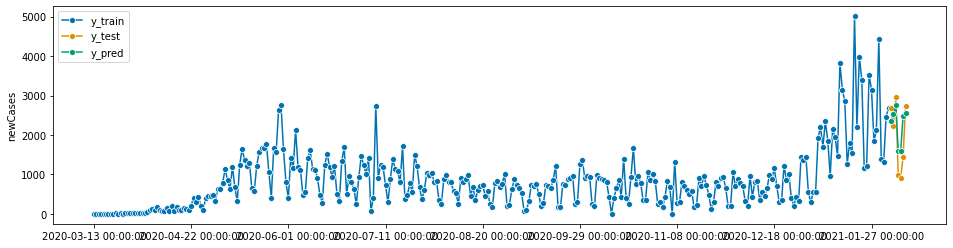

In [106]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])